In [46]:
# This is PyProb_Testing.ipynb converted to a script, fixing some errors.
# I've also reduced num_traces so that this script runs quickly.
# (See comments next to num_traces below for original values.)
import pyprob
import numpy as np
import torch

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from pyprob.util import InferenceEngine

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

In [47]:
obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
       [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
       [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
       [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
       [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
       [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
       [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
       [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
       [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
       [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
       [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
       [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
       [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
       [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
       [12.21401828,  6.76059035,  6.94920042,  7.42823701],
       [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
       [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
       [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
       [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
       [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
       [15.40023764,  9.10884407,  8.93836964,  8.61970667],
       [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
       [19.81054106, 11.90268453, 11.60989346, 10.76953856],
       [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
       [25.74331932, 15.63430056, 14.83860792, 14.07189108],
       [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
       [12.34604239,  7.78770185,  6.76075998,  6.78498685],
       [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
       [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
       [16.28983576,  9.66683929,  9.24891886,  9.28970032],
       [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
       [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
       [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
       [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
       [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]], dtype=torch.float64)


QCD_mass = 30.
#rate=torch.tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = np.array([1,1,1])
jetP = 400.
jetvec = jetP * jetdir / np.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = torch.tensor(0.3**2)
M2start = torch.tensor(QCD_mass**2)
jetM = np.sqrt(M2start.numpy()) ## Mass of initial jet
jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100

def dummy_bernoulli(self, jet):
    return True

class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
    def forward(self, inputs=None):
        assert inputs is None # Modify code if this ever not met?
        # Sample parameter of interest from Unif(0,10) prior
        root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                            name="decay_rate_parameter")
        decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                   name="decay_rate_parameter")
        # Simulator code needs two decay rates for (1) root note (2) all others
        # For now both are set to the same value
        inputs = [root_rate, decay_rate]
        return super().forward(inputs)

# Make instance of the simulator
simulator = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=float(pt_min),  # minimum pT for resulting jet
                              Delta_0= M2start,  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=1,  # minimum number of jet constituents
                              maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              bool_func=dummy_bernoulli,
                              suppress_output=True,
                              obs_leaves=obs_leaves)


In [48]:
simulator2 = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=float(pt_min),  # minimum pT for resulting jet
                              Delta_0= M2start,  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=1,  # minimum number of jet constituents
                              maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              bool_func=dummy_bernoulli,
                              suppress_output=True,
                              obs_leaves=obs_leaves)

# Check behaviour of simulator with different inputs

In [49]:
def leaf_count(tree):
    return len(tree['leaves'])
    

In [50]:
data = {i:[] for i in range(1,11)}
for i in range(1,11):
    for j in range(100):
        data[i].append(simulator2([i,i]))

In [ ]:
leaf_counts = {i:[] for i in range(1,11)}
for i in range(1,11):
    for j in range(100):
        leaf_counts[i].append(leaf_count(data[i][j]))

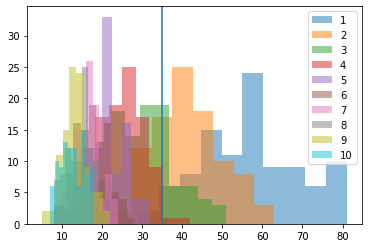

In [27]:
for i in range(1,11):
    plt.hist(leaf_counts[i], alpha = 0.5, label='{}'.format(i))
plt.legend(loc='upper right')
plt.axvline(len(obs_leaves))
plt.show()

Fore more clarity, skip every other.

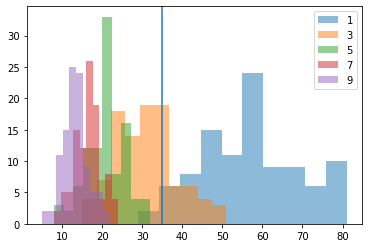

In [28]:
for i in range(1,11,2):
    plt.hist(leaf_counts[i], alpha = 0.5, label='{}'.format(i))
plt.legend(loc='upper right')
plt.axvline(len(obs_leaves))
plt.show()

# Train and test inference network

In [10]:
# Test run
simulator.train(iterations = 1,
    importance_sample_size=5000, 
    proposal_mixture_components=5,
    observe_embeddings={'bool_func': {'dim': 1, 'depth': 1}} # Dummy value as we currently have to observe something
)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------------------------ |  103/5000 |   2.23 | 0.65       
------------------------------------------------ |  330/5000 |   6.45 | 0.61       
------------------------------#----------------- |  629/5000 |  11.25 | 0.62       
------------------------------#----------------- |  655/5000 |   2.98 | 0.62       
------------------------------#----------------- |  688/5000 |   3.03 | 0.62       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarni

------------------------------#----------------- |  819/5000 |   4.29 | 0.62       
------------------------------##---------------- |  966/5000 |   5.33 | 0.63       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.wa

------------------------------####-------------- | 1543/5000 |   4.40 | 0.63       
------------------------------#####------------- | 1729/5000 |   4.50 | 0.33       
------------------------------######------------ | 1876/5000 |   4.98 | 0.33       
------------------------------######------------ | 1914/5000 |   5.65 | 0.33       
------------------------------######------------ | 2079/5000 |   6.54 | 0.33       
------------------------------########---------- | 2560/5000 |   7.10 | 0.34       
------------------------------########---------- | 2591/5000 |   7.19 | 0.34       
------------------------------########---------- | 2593/5000 |   7.19 | 0.34       
------------------------------#########--------- | 2818/5000 |   7.22 | 0.34       
------------------------------##########-------- | 3039/5000 |   8.59 | 0.34       
------------------------------##########-------- | 3089/5000 |   8.59 | 0.34       
------------------------------###########------- | 3136/5000 |   8.71 | 0.34

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___travers

------------------------------############------ | 3497/5000 |   9.42 | 0.12       
------------------------------############------ | 3526/5000 |   9.43 | 0.13       
------------------------------#############----- | 3662/5000 |  10.09 | 0.13       
------------------------------##############---- | 4014/5000 |  10.89 | 0.13       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

------------------------------###############--- | 4224/5000 |  11.20 | 0.13       
------------------------------################-- | 4530/5000 |  12.04 | 0.14       
------------------------------################-- | 4586/5000 |  12.04 | 0.14       
------------------------------#################- | 4783/5000 |  12.50 | 0.14       
0d:10:03:19 | 0d:00:00:07 | #################### | 5000/5000 |  13.08 | 0.14       
OfflineDataset at: .
Num. traces      : 500
Sorted on disk   : False
No pre-computed hashes found, generating: ./pyprob_hashes
Hashing offline dataset for sorting
Time spent  | Time remain.| Progress             | Traces  | Traces/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 500/500 | 34.39       
Sorting offline dataset
Sorting done
Num. trace types : 85
Trace hash	Count
82.55686951	3
94.10295868	5
103.18231964	210
139.11848450	16
146.72689819	1
146.82281494	5
154.12643433	2
158.16914368	15
158.19790649	15
166.14773560	1
170.16592407	1
171.16374207	9
174.10971069

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_

------------------------------------------------ |  362/5000 |   3.18 | 0.51       
------------------------------------------------ |  408/5000 |   4.76 | 0.50       
------------------------------------------------ |  472/5000 |   4.96 | 0.49       
------------------------------------------------ |  559/5000 |   5.11 | 0.48       
------------------------------#----------------- |  730/5000 |   5.38 | 0.47       
------------------------------#----------------- |  873/5000 |   5.77 | 0.44       
------------------------------####-------------- | 1465/5000 |   6.60 | 0.43       
------------------------------######------------ | 2001/5000 |   7.63 | 0.41       
------------------------------#######----------- | 2291/5000 |  10.07 | 0.32       


In [7]:
simulator.save_inference_network('ginkgo_network2')

# Plots

In [29]:
simulator.load_inference_network('ginkgo_network2')

In [30]:
posterior_test = simulataor.posterior(num_traces=1000,inference_engine=InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,observe={"bool_func": 1})

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pypro

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__16
  warnings.warn('Using prior. No proposal fo

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Using prior. No proposal fo

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___tra

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 490__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__17

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 490__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------##---------------- |  184/1000 |   2.74 | 0.22       


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:300: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pypro

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__18

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 490__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal f

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__19

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address

------------------------------#########--------- |  540/1000 |   8.30 | 0.33       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 490__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------############------ |  721/1000 |   8.06 | 0.38       


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:346: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:468: UserWarning: nan detected in jet['leaves'], returning distance of 1e6
  warn("nan detected in jet['leaves'], returning distance of 1e6")


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

------------------------------################-- |  895/1000 |  12.73 | 0.42       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 186__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 230__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 440__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

------------------------------################## |  978/1000 |   1.29 | 0.44       
0d:00:37:42 | 0d:00:00:02 | #################### | 1000/1000 |   1.35 | 0.44       


Appears that something has gone wrong with loading inference network.

In [41]:
lambdas = []
for i in range(1000):
    lambdas.append(posterior_test.values[i].result['Lambda'].detach().numpy())

lambdas_root = []
for i in range(1000):
    lambdas_root.append(posterior_test.values[i].result['LambdaRoot'].detach().numpy())

(array([115.,  77.,  98., 117., 109.,  97.,  90.,  97., 101.,  99.]),
 array([0.01709747, 1.015159  , 2.0132205 , 3.0112822 , 4.0093436 ,
        5.0074053 , 6.005467  , 7.0035286 , 8.00159   , 8.999652  ,
        9.997713  ], dtype=float32),
 <BarContainer object of 10 artists>)

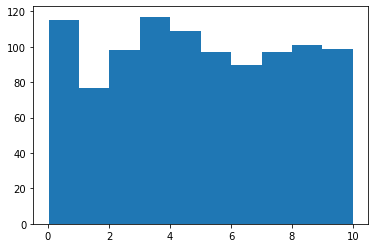

In [44]:
plt.hist(np.array(lambdas))

(array([100., 111., 116.,  95.,  99., 101.,  87.,  93.,  99.,  99.]),
 array([0.01645088, 1.0141232 , 2.0117955 , 3.009468  , 4.00714   ,
        5.0048127 , 6.0024853 , 7.0001574 , 7.99783   , 8.995502  ,
        9.993175  ], dtype=float32),
 <BarContainer object of 10 artists>)

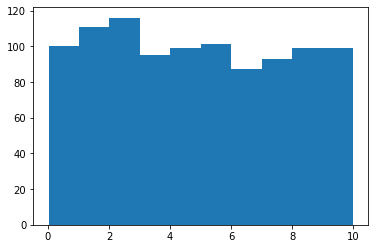

In [45]:
plt.hist(np.array(lambdas_root))

# Tests

In [9]:
len(simulator2([3,3])['leaves'])

38